In [1]:
import collections
import time

import numpy
import pandas

import qiskit
import qiskit.circuit.random
import qiskit_aer

from matplotlib import pyplot as plt
%matplotlib inline

## Create Random Circuits

In [2]:
random_circ = qiskit.circuit.random.random_circuit(
    num_qubits=3, depth=3, max_operands=4, measure=False, seed=35)
random_circ.draw(style='iqp')

┌───────────────────────┐┌─────────────────────────┐   
q_0: ┤ U2(0.60812,0.0056047) ├┤1                        ├─■─
     └─────────┬───┬─────────┘│  (XX+YY)(5.1079,1.0226) │ │ 
q_1: ──────────┤ S ├──────────┤0                        ├─■─
        ┌──────┴───┴───────┐  └──────────┬───┬──────────┘ │ 
q_2: ───┤ R(5.8748,5.9491) ├─────────────┤ T ├────────────■─
        └──────────────────┘             └───┘

In [3]:
standard_gates = qiskit.circuit.library.standard_gates

_basis_gate_set_1q = [
    (standard_gates.HGate, 1, 0),
    (standard_gates.RXGate, 1, 1),
    (standard_gates.RYGate, 1, 1),
    (standard_gates.RZGate, 1, 1),
]

_basis_gate_set_2q = [    
    (standard_gates.CXGate, 2, 0),
    (standard_gates.CYGate, 2, 0),
    (standard_gates.CZGate, 2, 0),
    (standard_gates.SwapGate, 2, 0),
]

_basis_gate_set_3q = [(standard_gates.CCXGate, 3, 0),]

basis_gate_set = {
    "1q": _basis_gate_set_1q,
    "2q": _basis_gate_set_2q,
    "3q": _basis_gate_set_3q
}

In [4]:
def get_basic_random_circuit(num_qubits, depth, gate_set, max_operands=4, measure=False, seed=None):
    """Generate random circuit of arbitrary size and form, given the allowed set of gates.
    
    Adopted from https://github.com/Qiskit/qiskit/blob/stable/1.0/qiskit/circuit/random/utils.py

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        gate_set (dict): keys specified as '(n)q', e.g. 1q or 2q, 3q, 4q for and multi-qubit gates
        max_operands (int): maximum qubit operands of each gate (between 1 and 4)
        measure (bool): if True, measure all qubits at the end
        seed (int): sets random seed (optional)

    Returns:
        QuantumCircuit: constructed circuit

    Raises:
        CircuitError: when invalid options given
    """
    np = numpy
    ClassicalRegister = qiskit.circuit.ClassicalRegister
    QuantumCircuit = qiskit.circuit.QuantumCircuit
    CircuitInstruction = qiskit.circuit.CircuitInstruction
    CircuitError = qiskit.circuit.exceptions.CircuitError
    
    if num_qubits == 0:
        return QuantumCircuit()
    if max_operands < 1 or max_operands > 4:
        raise CircuitError("max_operands must be between 1 and 4")
    max_operands = max_operands if num_qubits > max_operands else num_qubits

    gates_1q = gate_set.get("1q")
    gates_2q = gate_set.get("2q")
    gates_3q = gate_set.get("3q")
    gates_4q = gate_set.get("4q")

    gates = gates_1q.copy()
    if max_operands >= 2 and gates_2q != None:
        gates.extend(gates_2q)
    if max_operands >= 3 and gates_3q != None:
        gates.extend(gates_3q)
    if max_operands >= 4 and gates_4q != None:
        gates.extend(gates_4q)
        
    gates = np.array(
        gates, dtype=[("class", object), ("num_qubits", np.int64), ("num_params", np.int64)]
    )
    gates_1q = np.array(gates_1q, dtype=gates.dtype)

    qc = QuantumCircuit(num_qubits)

    if measure:
        cr = ClassicalRegister(num_qubits, "c")
        qc.add_register(cr)

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    qubits = np.array(qc.qubits, dtype=object, copy=True)

    # Apply arbitrary random operations in layers across all qubits.
    for layer_number in range(depth):
        # We generate all the randomness for the layer in one go.
        gate_specs = rng.choice(gates, size=len(qubits))
        
        cumulative_qubits = np.cumsum(gate_specs["num_qubits"], dtype=np.int64)
        # Efficiently find the point in the list where the total gates would use as many as
        # possible of, but not more than, the number of qubits in the layer.
        # If there's slack, fill it with 1q gates.
        max_index = np.searchsorted(cumulative_qubits, num_qubits, side="right")
        gate_specs = gate_specs[:max_index]
        slack = num_qubits - cumulative_qubits[max_index - 1]
        if slack:
            gate_specs = np.hstack((gate_specs, rng.choice(gates_1q, size=slack)))

        # For efficiency in the Python loop, this uses Numpy vectorisation to pre-calculate the
        # indices into the lists of qubits and parameters for every gate, and then suitably
        # randomises those lists.
        q_indices = np.empty(len(gate_specs) + 1, dtype=np.int64)
        p_indices = np.empty(len(gate_specs) + 1, dtype=np.int64)
        q_indices[0] = p_indices[0] = 0
        np.cumsum(gate_specs["num_qubits"], out=q_indices[1:])
        np.cumsum(gate_specs["num_params"], out=p_indices[1:])
        parameters = rng.uniform(0, 2 * np.pi, size=p_indices[-1])
        rng.shuffle(qubits)

        # We've now generated everything we're going to need.  Now just to add everything.
        for gate, q_start, q_end, p_start, p_end in zip(
            gate_specs["class"], q_indices[:-1], q_indices[1:], p_indices[:-1], p_indices[1:]
        ):
            operation = gate(*parameters[p_start:p_end])
            qc._append(CircuitInstruction(operation=operation, qubits=qubits[q_start:q_end]))

    if measure:
        qc.measure(qc.qubits, cr)

    return qc

In [5]:
basic_circ = get_basic_random_circuit(
    num_qubits=5, depth=4, gate_set=basis_gate_set, max_operands=4, measure=False, seed=32)
basic_circ.draw(style='iqp')

┌───┐┌────────────┐                        
q_0: ───────────────X────┤ X ├┤ Rz(2.5664) ├───────────■────────────
     ┌────────────┐ │    └─┬─┘└────────────┘┌───┐      │       ┌───┐
q_1: ┤ Rx(2.0291) ├─┼──X───┼────────────────┤ X ├──────┼───────┤ H ├
     └────────────┘ │  │   │                └─┬─┘      │       ├───┤
q_2: ───────────────X──┼───■────────X─────────┼────────┼───────┤ H ├
                       │   │        │         │        │       └───┘
q_3: ──────X───────────X───┼────────X─────────┼────────■────────────
           │               │                  │  ┌────────────┐     
q_4: ──────X───────────────■──────────────────■──┤ Rx(5.6852) ├─────
                                                 └────────────┘

## Shadow Tomography 

In [6]:
def shadow(circuit, shots=1, base='zzz'):
    """Make measurements using shadow tomography."""
    assert len(base) == len(circuit.qubits)
    circ = circuit.copy()

    # add rotations to measure in a given base
    for i, b in enumerate(base):
        if b == 'y':
            circ.sdg(i)
            circ.h(i)
        elif b == 'x':
            circ.h(i)
        elif b == 'z':
            pass
        else:
            raise KeyError
            
    # map the quantum measurement to the classical bits
    cr = qiskit.circuit.ClassicalRegister(circ.num_qubits, "c")
    circ.add_register(cr)
    circ.measure(circ.qubits, cr)
    
    # Use Aer's qasm_simulator
    backend_sim = qiskit_aer.Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    job_sim = backend_sim.run(qiskit.transpile(circ, backend_sim), shots=shots)

    counts = job_sim.result().get_counts(circ)
    counts = {tuple([int(i) for i in k]): v for k, v in counts.items()}    
    results = [k for k, v in counts.items() for _ in range(v)]
    
    return results

# test
shadow(basic_circ, shots=10, base='zzzxx')

[(0, 1, 0, 1, 0),
 (1, 0, 1, 1, 0),
 (0, 1, 0, 0, 0),
 (0, 0, 0, 0, 0),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 0, 0),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 0)]

## Main Measurements (qubits 5, depth x, n 100)

In [7]:
def measure(circ1, circ2, n=100):
    """Measure two circuits."""
    assert len(circ1.qubits) == len(circ2.qubits)
    size = len(circ1.qubits)
    
    result = []
    for base in numpy.random.choice(['x', 'y', 'z'], size=size*n).reshape(-1, size):
        s1 = shadow(circ1, shots=2, base=base)
        s2 = shadow(circ2, shots=2, base=base)
        result.append({'base': base, 'c1': s1[0], 'c2': s2[0], 'c1bis': s1[1], 'c2bis': s2[1]})
    return pandas.DataFrame(result)

In [8]:
results = []
for i in range(1, 25):
    circ1 = get_basic_random_circuit(num_qubits=i, depth=10, gate_set=basis_gate_set)
    circ2 = get_basic_random_circuit(num_qubits=i, depth=10, gate_set=basis_gate_set)
    m = measure(circ1, circ2, n=100)
    results.append(m)    

In [10]:
def simple_agreement(c1, c2):
    """Measure the agreement."""
    assert len(c1) == len(c2)
    r = [ai == bi for a, b in zip(c1.iloc, c2.iloc) for ai, bi in zip(a, b)]
    return numpy.array(r, dtype='int32').mean()

simple_agreement(results[5]['c1'], results[5]['c1bis'])

0.505

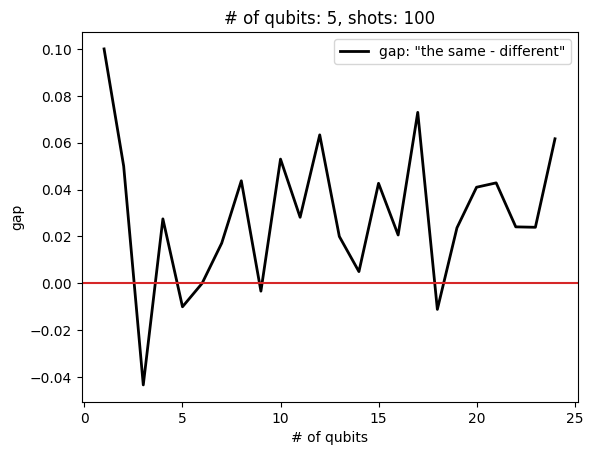

In [14]:
# the same
x = list(range(1, 25))
same = numpy.array([simple_agreement(results[i]['c1'], results[i]['c1bis']) for i in range(24)])
diff = numpy.array([simple_agreement(results[i]['c1'], results[i]['c2']) for i in range(24)])

plt.plot(x, same - diff, color='black', linewidth=2, label='gap: "the same - different"')

plt.axhline(y=0, color='tab:red', linestyle='-')

plt.legend()
plt.title('# of qubits: 5, shots: 100')
plt.xlabel('# of qubits')
plt.ylabel('gap')
plt.show()

## qiskit.quantum_info.hellinger_fidelity

In [15]:
count = lambda r: collections.Counter([''.join([str(s) for s in s]) for s in r])

display(qiskit.quantum_info.hellinger_fidelity(count(results[0]['c1']), count(results[0]['c1bis'])))
display(qiskit.quantum_info.hellinger_fidelity(count(results[0]['c1']), count(results[0]['c2'])))

0.9974423042781577

0.9025941969931681

In [16]:
def simple_hellinger(df):
    fidelity = qiskit.quantum_info.hellinger_fidelity
    same = fidelity(count(df['c1'].iloc[:i]), count(df['c1bis'].iloc[:i]))
    diff = fidelity(count(df['c1'].iloc[:i]), count(df['c2'].iloc[:i]))
    return same - diff

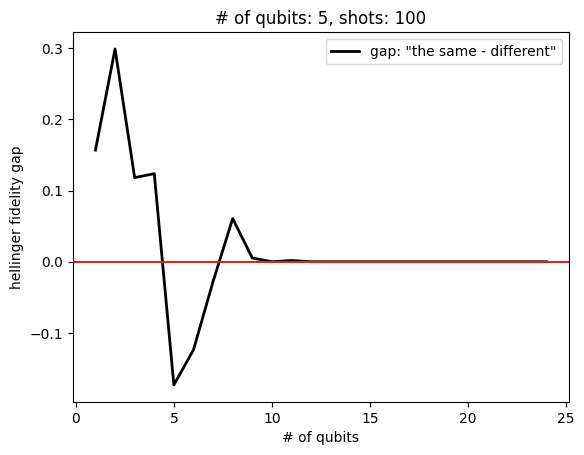

In [19]:
# the same
x = list(range(1, 25))
gap = numpy.array([simple_hellinger(results[i]) for i in range(24)])

plt.plot(x, gap, color='black', linewidth=2, label='gap: "the same - different"')

plt.axhline(y=0, color='tab:red', linestyle='-')

plt.legend()
plt.title('# of qubits: 5, shots: 100')
plt.xlabel('# of qubits')
plt.ylabel('hellinger fidelity gap')
plt.show()